In [505]:
import numpy as np
import matplotlib.pyplot as plt
from htmresearch.support.gridcells.context_integration.context_layer import ContextLayer
from scipy.stats import entropy
%matplotlib inline
%load_ext autoreload
%autoreload 2


# Hyper-module
m = 2
n = 17

# Layer
d = 2
l = (m*n*n)//d

module_shape = (m, n, n)
layer_shape  = (d, l)

zero = np.zeros(2*m)
dx   = np.zeros(2*m)
dy   = np.zeros(2*m)

dx[0:2] = np.array([1,0])
dy[0:2] = np.array([0,1])

action_tensor = np.zeros((m, 2, 2*m))
for i in range(m):
    theta = np.random.sample()*np.pi*2
    sixty = np.pi/3 + np.random.randn()*0.50
    s1     = 3 + np.random.sample()*27.
    s2     = 3 + np.random.sample()*27.
    
    action_tensor[i,:,0:2] = np.array([
        [ s1*np.cos(theta), s2*np.cos(theta + sixty)],
        [ s1*np.sin(theta), s2*np.sin(theta + sixty)]  
    ]).astype(int)
    
print dx
print np.dot(action_tensor[0,:,:], dx)
print action_tensor[0,:,:5]
# print action_tensor[0,:,:2]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[ 1.  0.  0.  0.]
[ -3.  21.]
[[ -3. -29.   0.   0.]
 [ 21.   5.   0.   0.]]


In [502]:
"""
Creating a 
binary code for features.
"""
def encode(digit, l, w=4):
    start = digit * l/10
    end = start + w
    return [ i%l for i in range(start, end)]

w = 3
F = np.zeros((10,d,l))
for i in range(10):
    F[i,:,encode(i%10, l, w)] = 1
    
print F[i].shape
print "Pattern weight:", w*d
print "Sparsity (bottom up):", float(w)/l

CL  = ContextLayer(layer_shape=(d,l), module_shape=(m,n,n), action_map = action_tensor, max_activity=(d*w)*10) 

print CL

(2, 289)
Pattern weight: 6
Sparsity (bottom up): 0.0103806228374
**Context Layer:**
Number of cells:	 578
Layer Shape:		 (2, 289)
Hyper-Module Shape:	 (2, 17, 17)
Activity bound:		 60


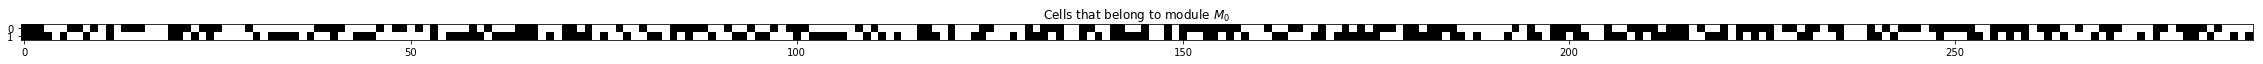

In [503]:
CL.clear()

# for i in range(m):
#     r = np.random.sample()
#     CL.set_individual_module(i, float(i)/(m-1)*np.ones((n,n)))
    
CL.set_individual_module(0, 10*np.ones((n,n)))

plt.figure(figsize=(40,20))
plt.title("Cells that belong to module $M_0$")
plt.imshow(CL.layer, cmap="binary", vmin=0, vmax=1)

CL.clear()

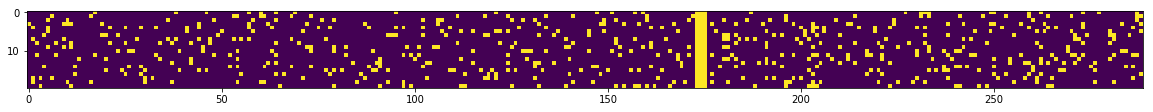

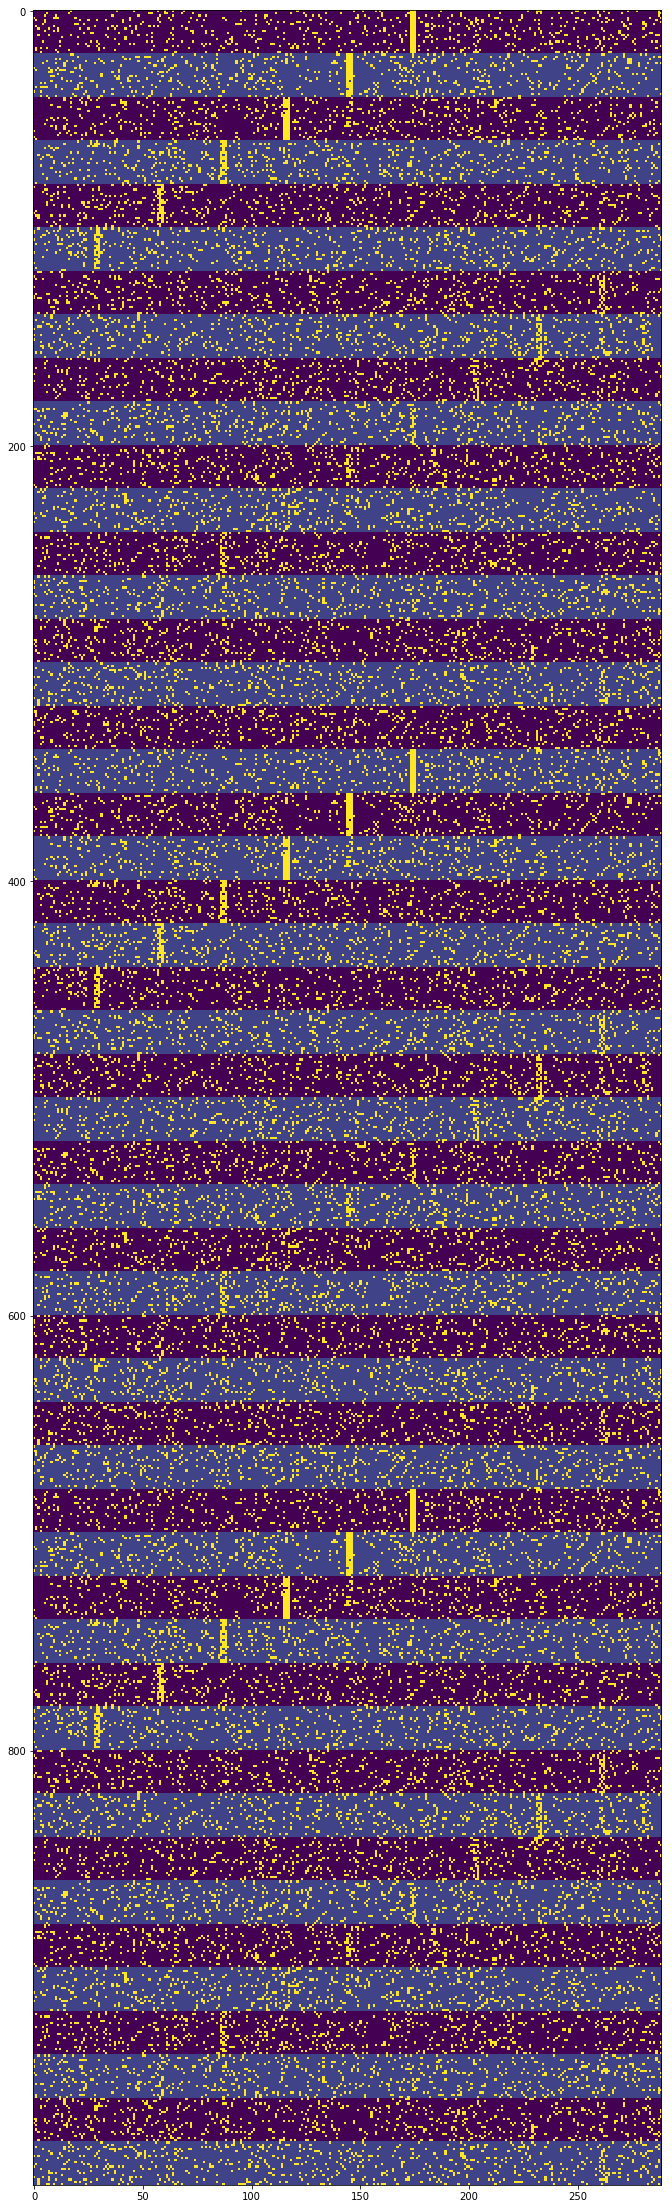

In [474]:
CL.clear()
CL.extend(zero, F[0])
T = 1500
for t in range(T):
    CL.extend(dx , F[1 + t%9])

plt.figure(figsize=(20,10))
plt.imshow(CL.layer)
plt.show()

plt.figure(figsize=(40,40))
img = np.concatenate([CL.explore(-t*dx, mentally=True) + (t%2)*0.2 for t in range(0,50)], axis=0)
plt.imshow(img, 
           cmap="viridis", vmin=0, vmax=1)
plt.show()
    

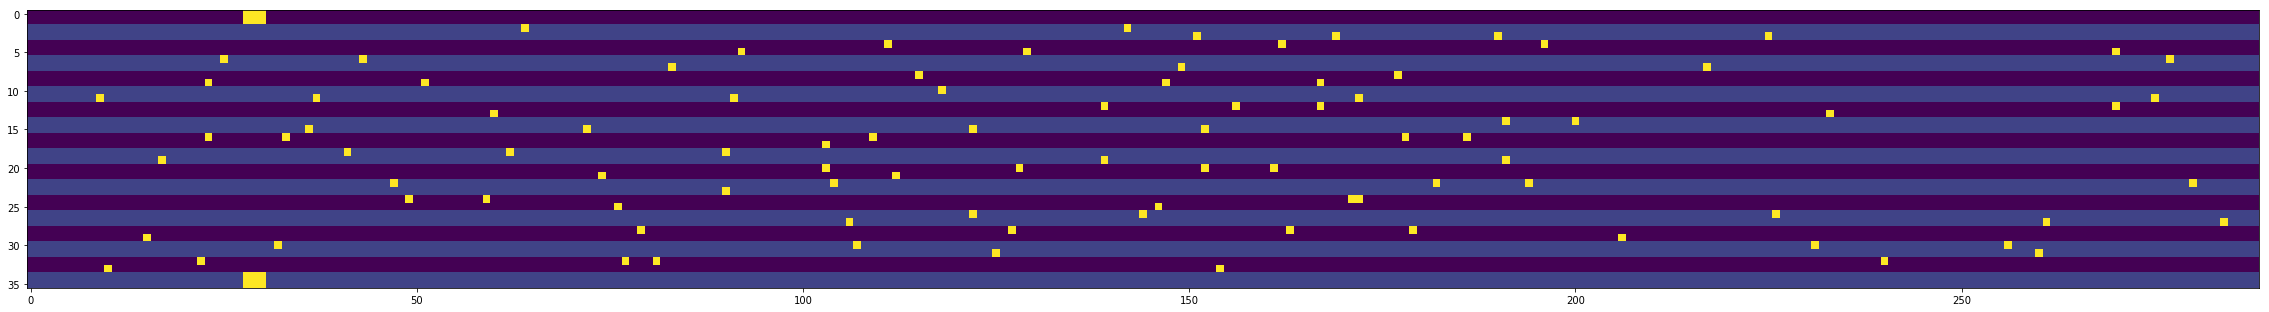

In [504]:
CL.clear()
CL.extend(0*dx,F[1])
img = np.concatenate([CL.explore(t*dx, mentally=True) + (t%2)*0.2 for t in range(0,18)], axis=0)
plt.figure(figsize=(40,40))
plt.imshow(img, 
           cmap="viridis", vmin=0, vmax=1)
plt.show()

In [1]:
"""
Creating an environment and 
a path of an agent
"""
from htmresearch.support.gridcells.random_walk import smooth_torus_walk

env = np.zeros((30,30))
env = (np.random.sample(env.shape) > 0.86).astype(float)

num_steps = 100000
X, _ = smooth_torus_walk(num_steps, start=[0.5,0.5], min_speed=0.02, max_speed=0.055, sigma=12.5)

X[:,0] *= (env.shape[0] )
X[:,1] *= (env.shape[1] )
X = X.astype(int)

V = np.zeros(X.shape)
for t in range( X.shape[0] - 1):
    V[t,:] = X[t+1] - X[t] 

plt.xlim(0., env.shape[1]);
plt.ylim(0., env.shape[0]);
plt.hist2d(X[0:1000,1],X[0:1000,0], bins=np.arange(40));
plt.show()   
plt.imshow(env , cmap="binary", vmin=0, vmax=1)
plt.show()

NameError: name 'np' is not defined

number of features visited: 48


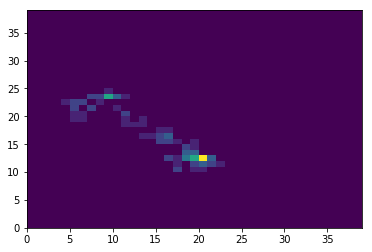

2500
2520
2540
2560
2580
2600
2620
2640
2660
2680


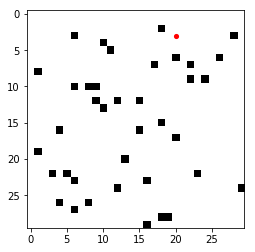

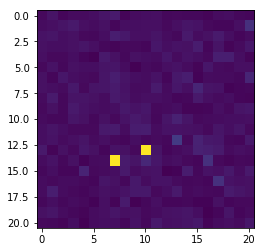

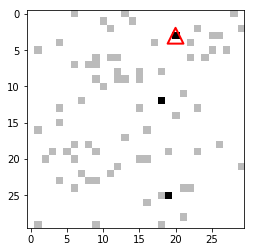

In [226]:


env = (np.random.sample(env.shape) < 0.05).astype(float)
CL  = ContextLayer(layer_shape=(d,m), module_shape=(n,n), action_map = action_matrix, max_activity=600) 




mask = np.zeros((11,11))
env_tensor = np.zeros((mask.shape[0], mask.shape[1], env.shape[0],env.shape[1]))
for x in range(env.shape[0]):
        for y in range(env.shape[1]):
            xs = [  k%env.shape[0] for k in range(x - mask.shape[0]//2 ,x + mask.shape[0]//2 + 1 )]
            ys = [  k%env.shape[1] for k in range(y - mask.shape[1]//2 ,y + mask.shape[1]//2 +1 ) ] 
            env_snip = env[xs,:][:,ys]
            env_tensor[:,:,x,y] = env_snip[:,:]


def position_estimate(CL, env_tensor):
    heat = np.zeros(env.shape)

    mask = CL.decode_bw(5)
    mask = mask - np.amin(mask)
    if np.amax(mask) > 0:
        mask = mask/np.amax(mask)
    mask = (mask > 0.8).astype(float)
    
    mask = mask.reshape((11,11,1,1))

    heat = np.sum(env_tensor*mask, axis=(0,1)) - 0*np.sum(env_tensor, axis=(0,1))

    
    prob = np.exp(heat)
#     prob = heat
    prob = prob/np.sum(prob)
    return prob
    
    
    



# T = X.shape[0]
T = 50
heatmap_agent = np.zeros(env.shape)
    
movie_frames = []

count = 0
for t in range(0,1000):
    CL.explore(V[t].astype(int))
    
    pos = X[t+1] 
    
    heatmap_agent *= 0.99
    heatmap_agent[pos[0],pos[1]] = 1
    
    f_id = int(env[pos[0],pos[1]] )
    if f_id > 0:
        count += 1
        CL.extend([0,0], FEATURE[ f_id ])
        
print "number of features visited:", count
plt.hist2d(X[2500:2600,1],X[2500:2600,0], bins=np.arange(40));
plt.show()  
for t in range(2500,2700):
    CL.explore(V[t].astype(int))
    
    pos = X[t+1] 
    if t%20==0:
        print t
    heatmap_agent *= 0.99
    heatmap_agent[pos[0],pos[1]] = 1
    
    f_id = int(env[pos[0],pos[1]] )
    if f_id > 0:
        CL.extend([0,0], FEATURE[ f_id ])
    
    prob = position_estimate(CL, env_tensor)
    movie_frames.append(prob)
        
# plt.imshow(- env + 6*(env * heatmap_agent), cmap="binary", vmin=0, vmax=5)
# plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
# plt.show()

# plt.figure(figsize=(10,10))
plt.imshow(env, cmap="binary", vmin=0, vmax=1)
plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()

mask = CL.decode_bw(10)
mask = mask - np.amin(mask)
if np.amax(mask) > 0:
    mask = mask/np.amax(mask)
# mask = (mask > 0.8).astype(float)
plt.imshow(mask)
plt.show()

prob = position_estimate(CL, env_tensor)

# plt.imshow(prob, cmap='binary', interpolation='bicubic')
plt.imshow(prob, cmap='binary', interpolation='none')
plt.scatter(X[t+1,1],X[t+1,0], s=250, marker="^", c="none", edgecolor='red',  lw = 2)
plt.show()



KeyboardInterrupt: 

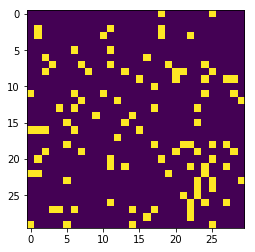

In [216]:
import matplotlib.animation as manimation



filename = "test.html"
title = "test"
fps=15
dpi=100

FFMpegWriter = manimation.writers['html']
metadata = dict(title='Movie Test', artist='Matplotlib',
            comment='Movie support!')
metadata     = dict(title=title)
writer       = FFMpegWriter(fps=fps, metadata=metadata)
fig = plt.figure()

with writer.saving(fig, filename, dpi):
    for s in range(len(movie_frames)):
        plt.imshow(movie_frames[s])
        writer.grab_frame()





6.49185309633
6.49185309633
